# Part B : News Article Classification

## Loading Data

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/kaggle/input/ist-nlp-news-dataset/data_news - data_news.csv')
df.head()

,category,headline,links,short_description,keywords
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug
3,WELLNESS,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life
4,WELLNESS,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           50000 non-null  object
 1   headline           50000 non-null  object
 2   links              50000 non-null  object
 3   short_description  50000 non-null  object
 4   keywords           47332 non-null  object
dtypes: object(5)
memory usage: 1.9+ MB


## Combining all textual columns

In [15]:
df['text'] = df['headline'] + '. ' + df['short_description']

df.head()

,category,headline,links,short_description,keywords,text
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons,143 Miles in 35 Days: Lessons Learned. Resting...
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy,Talking to Yourself: Crazy or Crazy Helpful?. ...
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug,Crenezumab: Trial Will Gauge Whether Alzheimer...
3,WELLNESS,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life,"Oh, What a Difference She Made. If you want to..."
4,WELLNESS,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods,"Green Superfoods. First, the bad news: Soda br..."


## Cleaning Data

In [16]:
# Lowercasing Category column data
df['category'] = df['category'].astype(str).str.lower().str.strip()

# Removing Unnecessary columns
df = df[['text', 'category']].copy()

# Dropping Empty rows
df = df.dropna(subset=['text', 'category'])
df = df.reset_index(drop=True)

## Understanding Class Distribution

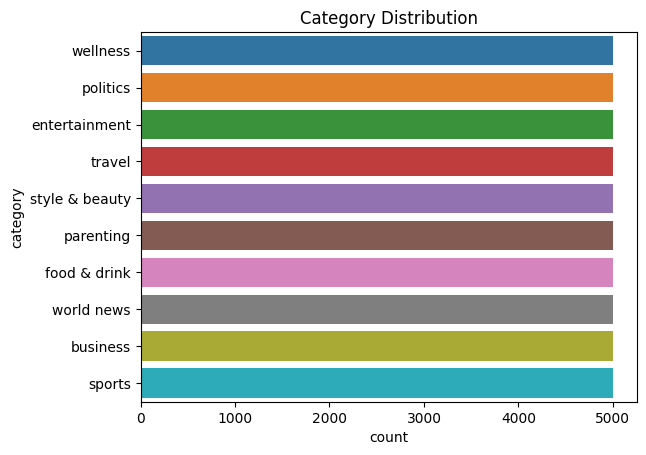

In [17]:
sns.countplot(y=df['category'], order=df['category'].value_counts().index)
plt.title("Category Distribution")
plt.show()

*  **All classes have equal distribution**
*  **Each class has a word count of 5000**

## Feature Extraction

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['category'])

print("Label classes:", le.classes_)

Label classes: ['business' 'entertainment' 'food & drink' 'parenting' 'politics' 'sports'
 'style & beauty' 'travel' 'wellness' 'world news']


## Train-Test Split

In [19]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(len(X_train), len(X_test))

40000 10000


## Bag-Of-Words

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=3
)

X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

This gives a sparse matrix of raw word counts.

## TF-IDF

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=3
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

TF-IDF almost always performs better than BoW for news classification.

## Word2Vec

In [22]:
from gensim.models import Word2Vec

sentences = [text.split() for text in df['text']]

w2v_model = Word2Vec(
    sentences,
    vector_size=100,   
    window=5,
    min_count=3,
    workers=4,
    sg=1              
)

w2v_model.train(sentences, total_examples=len(sentences), epochs=10)

(12851613, 16166220)

## Converting Article to Avg Embedding

In [23]:
import numpy as np

def get_w2v_vector(text):
    tokens = text.split()
    vectors = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    return np.mean(vectors, axis=0) if len(vectors) > 0 else np.zeros(100)

X_train_w2v = np.vstack([get_w2v_vector(t) for t in X_train])
X_test_w2v  = np.vstack([get_w2v_vector(t) for t in X_test])

Word2Vec embeddings capture semantics but lose phrase structure.

## 1. Logistic Regression

### 1.1 Bag-Of-Words

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


logreg_bow = LogisticRegression(max_iter=3000, n_jobs=-1)

logreg_bow.fit(X_train_bow, y_train)
bow_preds = logreg_bow.predict(X_test_bow)

print("LogReg + BoW")
print("Accuracy :", accuracy_score(y_test, bow_preds))
print("Precision:", precision_score(y_test, bow_preds, average='weighted'))
print("Recall   :", recall_score(y_test, bow_preds, average='weighted'))
print("F1-score :", f1_score(y_test, bow_preds, average='weighted'))

LogReg + BoW
Accuracy : 0.8122
Precision: 0.8125339057767115
Recall   : 0.8122
F1-score : 0.8119348970621656


### 1.2 TF-IDF

In [25]:
logreg_tfidf = LogisticRegression(max_iter=3000, n_jobs=-1)

logreg_tfidf.fit(X_train_tfidf, y_train)
tfidf_preds = logreg_tfidf.predict(X_test_tfidf)

print("LogReg + TF-IDF")
print("Accuracy :", accuracy_score(y_test, tfidf_preds))
print("Precision:", precision_score(y_test, tfidf_preds, average='weighted'))
print("Recall   :", recall_score(y_test, tfidf_preds, average='weighted'))
print("F1-score :", f1_score(y_test, tfidf_preds, average='weighted'))


LogReg + TF-IDF
Accuracy : 0.8103
Precision: 0.8120161269598506
Recall   : 0.8103
F1-score : 0.8107759658337114


### 1.3 Word2Vec

In [26]:
logreg_w2v = LogisticRegression(max_iter=3000)

logreg_w2v.fit(X_train_w2v, y_train)
w2v_preds = logreg_w2v.predict(X_test_w2v)

print("LogReg + Word2Vec")
print("Accuracy :", accuracy_score(y_test, w2v_preds))
print("Precision:", precision_score(y_test, w2v_preds, average='weighted'))
print("Recall   :", recall_score(y_test, w2v_preds, average='weighted'))
print("F1-score :", f1_score(y_test, w2v_preds, average='weighted'))


LogReg + Word2Vec
Accuracy : 0.6842
Precision: 0.6866267604520813
Recall   : 0.6842
F1-score : 0.6844944315236418


## 2. Naive Bayes

### 2.1 Bag-Of-Words

In [27]:
from sklearn.naive_bayes import MultinomialNB

nb_bow = MultinomialNB()

nb_bow.fit(X_train_bow, y_train)
nb_bow_preds = nb_bow.predict(X_test_bow)

print("Naive Bayes + BoW")
print("Accuracy :", accuracy_score(y_test, nb_bow_preds))
print("Precision:", precision_score(y_test, nb_bow_preds, average='weighted'))
print("Recall   :", recall_score(y_test, nb_bow_preds, average='weighted'))
print("F1-score :", f1_score(y_test, nb_bow_preds, average='weighted'))

Naive Bayes + BoW
Accuracy : 0.7799
Precision: 0.7835162576753295
Recall   : 0.7799
F1-score : 0.7807514170706156


### 2.2 TF-IDF

In [28]:
nb_tfidf = MultinomialNB()

nb_tfidf.fit(X_train_tfidf, y_train)
nb_tfidf_preds = nb_tfidf.predict(X_test_tfidf)

print("Naive Bayes + TF-IDF")
print("Accuracy :", accuracy_score(y_test, nb_tfidf_preds))
print("Precision:", precision_score(y_test, nb_tfidf_preds, average='weighted'))
print("Recall   :", recall_score(y_test, nb_tfidf_preds, average='weighted'))
print("F1-score :", f1_score(y_test, nb_tfidf_preds, average='weighted'))


Naive Bayes + TF-IDF
Accuracy : 0.7839
Precision: 0.7895238755118537
Recall   : 0.7839
F1-score : 0.7852160866775013


## 3. Support Vector Machine (SVM)

### 3.1 Bag-Of-Words

In [29]:
from sklearn.svm import LinearSVC

svm_bow = LinearSVC()

svm_bow.fit(X_train_bow, y_train)
svm_bow_preds = svm_bow.predict(X_test_bow)

print("SVM + BoW")
print("Accuracy :", accuracy_score(y_test, svm_bow_preds))
print("Precision:", precision_score(y_test, svm_bow_preds, average='weighted'))
print("Recall   :", recall_score(y_test, svm_bow_preds, average='weighted'))
print("F1-score :", f1_score(y_test, svm_bow_preds, average='weighted'))

SVM + BoW
Accuracy : 0.794
Precision: 0.7939772034911611
Recall   : 0.794
F1-score : 0.7936267152140182


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### 3.2 TF-IDF

In [30]:
svm_tfidf = LinearSVC()

svm_tfidf.fit(X_train_tfidf, y_train)
svm_tfidf_preds = svm_tfidf.predict(X_test_tfidf)

print("SVM + TF-IDF")
print("Accuracy :", accuracy_score(y_test, svm_tfidf_preds))
print("Precision:", precision_score(y_test, svm_tfidf_preds, average='weighted'))
print("Recall   :", recall_score(y_test, svm_tfidf_preds, average='weighted'))
print("F1-score :", f1_score(y_test, svm_tfidf_preds, average='weighted'))


SVM + TF-IDF
Accuracy : 0.8216
Precision: 0.8217747086801018
Recall   : 0.8216
F1-score : 0.8214480069566498


### 3.3 Word2Vec

In [31]:
svm_w2v = LinearSVC()

svm_w2v.fit(X_train_w2v, y_train)
svm_w2v_preds = svm_w2v.predict(X_test_w2v)

print("SVM + Word2Vec")
print("Accuracy :", accuracy_score(y_test, svm_w2v_preds))
print("Precision:", precision_score(y_test, svm_w2v_preds, average='weighted'))
print("Recall   :", recall_score(y_test, svm_w2v_preds, average='weighted'))
print("F1-score :", f1_score(y_test, svm_w2v_preds, average='weighted'))

SVM + Word2Vec
Accuracy : 0.6741
Precision: 0.6749442396720668
Recall   : 0.6741
F1-score : 0.6724300969219551


## Comparison Table

In [32]:
import pandas as pd

results = []

# Logistic Regression
results.append(["LogReg", "BoW",
                accuracy_score(y_test, bow_preds),
                precision_score(y_test, bow_preds, average='weighted'),
                recall_score(y_test, bow_preds, average='weighted'),
                f1_score(y_test, bow_preds, average='weighted')])

results.append(["LogReg", "TF-IDF",
                accuracy_score(y_test, tfidf_preds),
                precision_score(y_test, tfidf_preds, average='weighted'),
                recall_score(y_test, tfidf_preds, average='weighted'),
                f1_score(y_test, tfidf_preds, average='weighted')])

results.append(["LogReg", "Word2Vec",
                accuracy_score(y_test, w2v_preds),
                precision_score(y_test, w2v_preds, average='weighted'),
                recall_score(y_test, w2v_preds, average='weighted'),
                f1_score(y_test, w2v_preds, average='weighted')])

# Naive Bayes
results.append(["Naive Bayes", "BoW",
                accuracy_score(y_test, nb_bow_preds),
                precision_score(y_test, nb_bow_preds, average='weighted'),
                recall_score(y_test, nb_bow_preds, average='weighted'),
                f1_score(y_test, nb_bow_preds, average='weighted')])

results.append(["Naive Bayes", "TF-IDF",
                accuracy_score(y_test, nb_tfidf_preds),
                precision_score(y_test, nb_tfidf_preds, average='weighted'),
                recall_score(y_test, nb_tfidf_preds, average='weighted'),
                f1_score(y_test, nb_tfidf_preds, average='weighted')])

# SVM
results.append(["SVM", "BoW",
                accuracy_score(y_test, svm_bow_preds),
                precision_score(y_test, svm_bow_preds, average='weighted'),
                recall_score(y_test, svm_bow_preds, average='weighted'),
                f1_score(y_test, svm_bow_preds, average='weighted')])

results.append(["SVM", "TF-IDF",
                accuracy_score(y_test, svm_tfidf_preds),
                precision_score(y_test, svm_tfidf_preds, average='weighted'),
                recall_score(y_test, svm_tfidf_preds, average='weighted'),
                f1_score(y_test, svm_tfidf_preds, average='weighted')])

results.append(["SVM", "Word2Vec",
                accuracy_score(y_test, svm_w2v_preds),
                precision_score(y_test, svm_w2v_preds, average='weighted'),
                recall_score(y_test, svm_w2v_preds, average='weighted'),
                f1_score(y_test, svm_w2v_preds, average='weighted')])

comparison_df = pd.DataFrame(
    results,
    columns=["Model", "Features", "Accuracy", "Precision", "Recall", "F1-score"]
)

comparison_df.sort_values("F1-score", ascending=False)


,Model,Features,Accuracy,Precision,Recall,F1-score
6,SVM,TF-IDF,0.8216,0.821775,0.8216,0.821448
0,LogReg,BoW,0.8122,0.812534,0.8122,0.811935
1,LogReg,TF-IDF,0.8103,0.812016,0.8103,0.810776
5,SVM,BoW,0.7940,0.793977,0.7940,0.793627
4,Naive Bayes,TF-IDF,0.7839,0.789524,0.7839,0.785216
3,Naive Bayes,BoW,0.7799,0.783516,0.7799,0.780751
2,LogReg,Word2Vec,0.6842,0.686627,0.6842,0.684494
7,SVM,Word2Vec,0.6741,0.674944,0.6741,0.672430


## Best model

In [33]:
best_row = comparison_df.sort_values("F1-score", ascending=False).iloc[0]
best_row


Model             SVM
Features       TF-IDF
Accuracy       0.8216
Precision    0.821775
Recall         0.8216
F1-score     0.821448
Name: 6, dtype: object

* Based on comparative evaluation across multiple models and feature representations, SVM with TF-IDF features achieved the highest F1-score and was selected as the final model for further analysis.

## Deriving Insights from the best model

* Since LinearSVC's coefficients are harder to interpret.
* We use the same TF-IDF features with logistic regression for analysis.

In [34]:
import numpy as np

feature_names = tfidf_vectorizer.get_feature_names_out()
top_n = 15

for class_idx, class_name in enumerate(le.classes_):
    print(f"\nTop keywords for category: {class_name.upper()}")
    
    coef = logreg_tfidf.coef_[class_idx]
    top_indices = np.argsort(coef)[-top_n:][::-1]
    
    for idx in top_indices:
        print(feature_names[idx])



Top keywords for category: BUSINESS
business
ceo
company
companies
leadership
jobs
uber
workers
financial
walmart
marketing
corporate
billion
employees
economy

Top keywords for category: ENTERTAINMENT
film
movie
trailer
music
actor
singer
star
album
jenner
movies
netflix
show
films
her
hollywood

Top keywords for category: FOOD & DRINK
recipes
food
recipe
wine
cooking
cocktails
cheese
kitchen
chef
taste
beer
cook
chocolate
chicken
drink

Top keywords for category: PARENTING
kids
baby
parenting
parents
children
mom
moms
parent
child
babies
my
toddler
breastfeeding
daughter
kid

Top keywords for category: POLITICS
gop
republicans
obama
clinton
senate
republican
democrats
congress
democratic
state
political
governor
house
americans
hillary

Top keywords for category: SPORTS
nfl
sports
football
team
game
nba
olympic
players
baseball
soccer
olympics
player
fan
lebron
athletes

Top keywords for category: STYLE & BEAUTY
photos
fashion
style
hair
beauty
photo
dress
makeup
model
designer
kate

## Visualizing

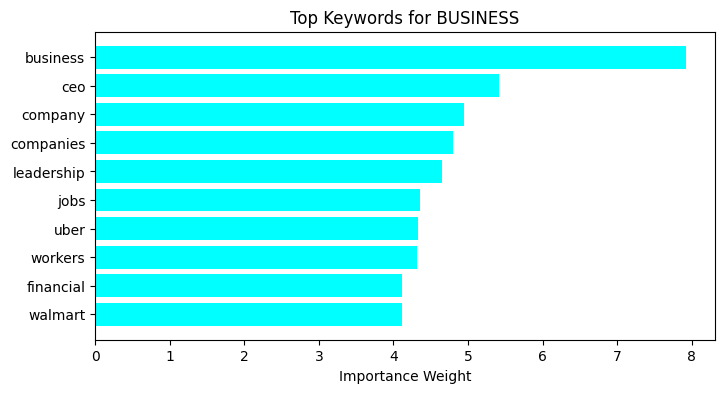

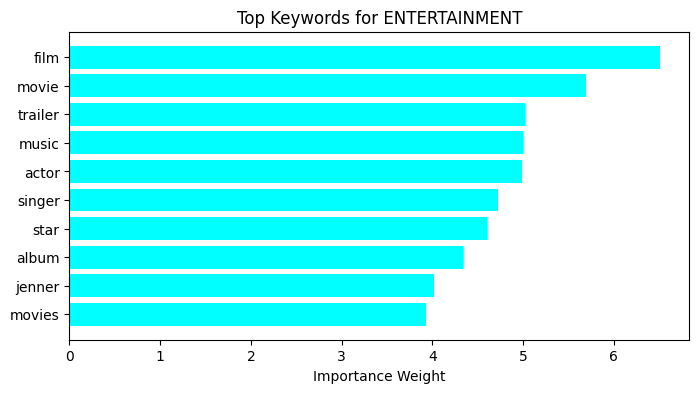

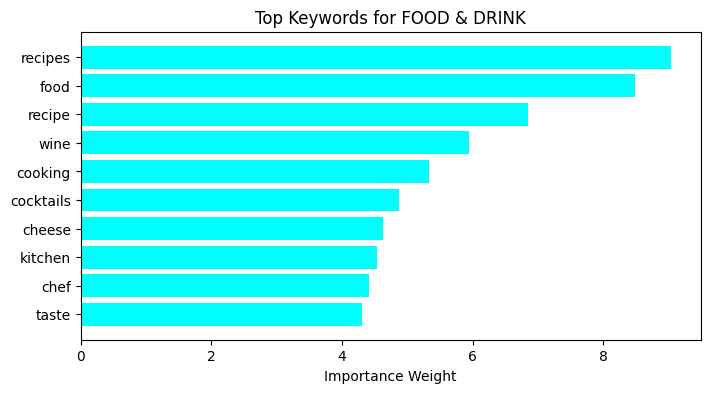

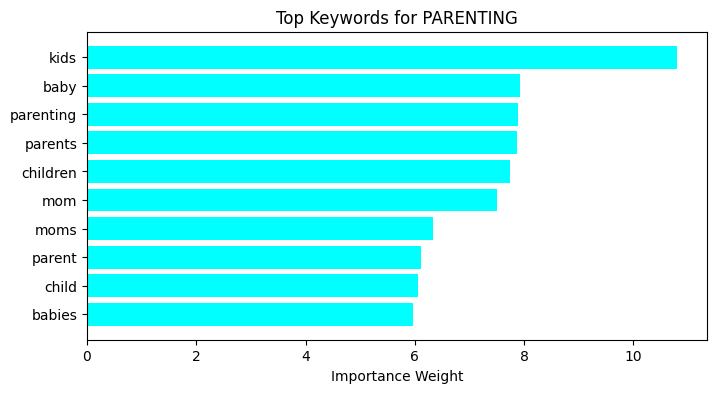

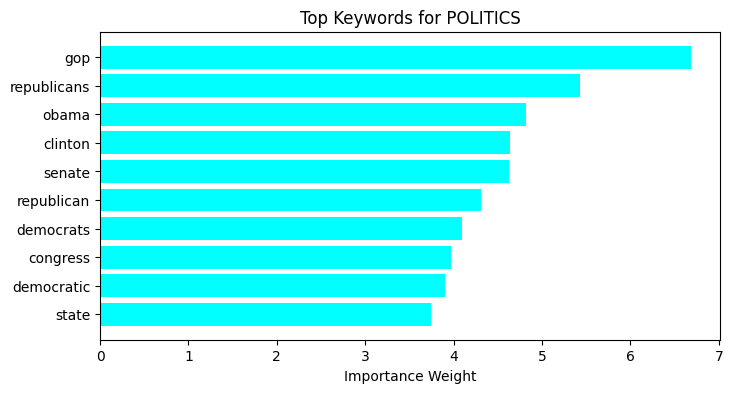

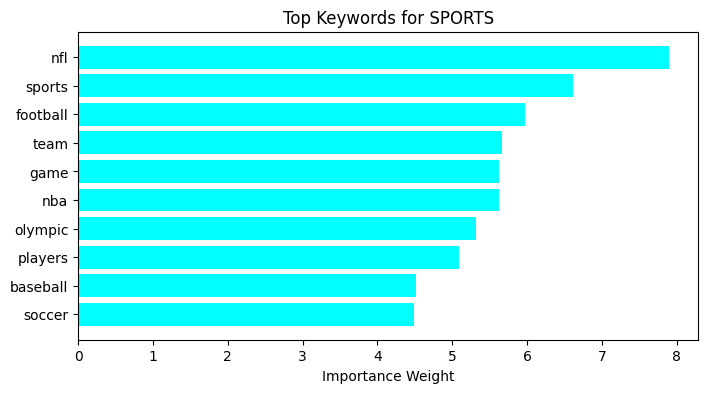

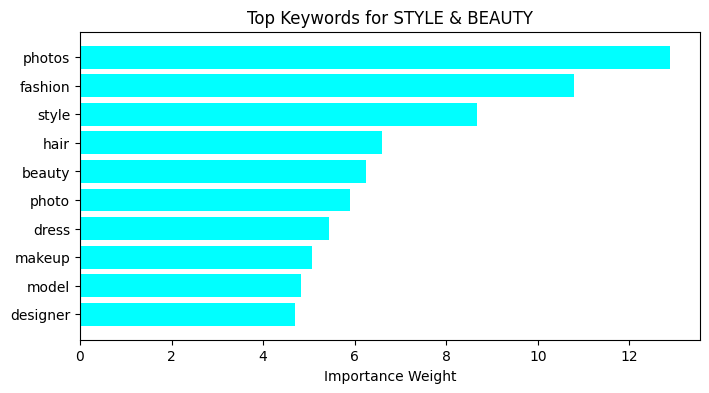

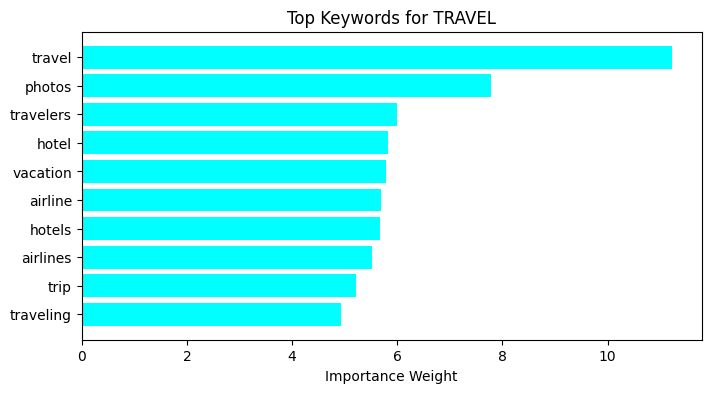

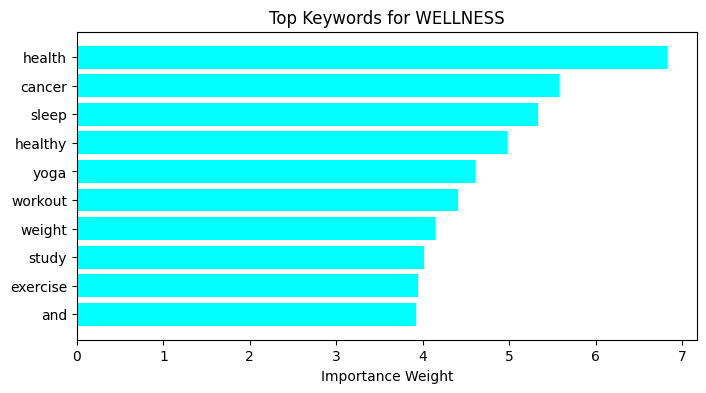

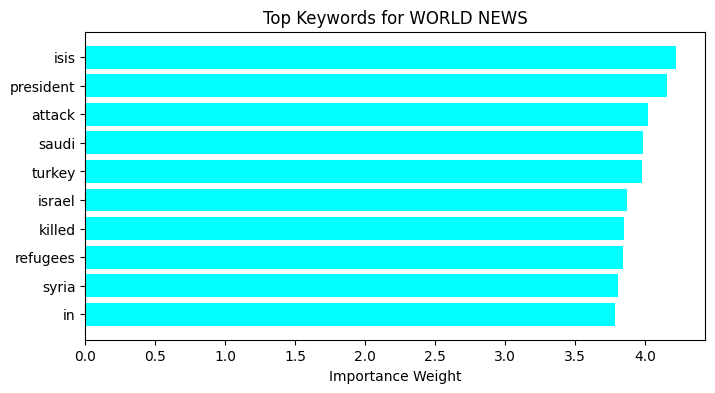

In [35]:
import matplotlib.pyplot as plt

for class_idx, class_name in enumerate(le.classes_):
    coef = logreg_tfidf.coef_[class_idx]
    top_indices = np.argsort(coef)[-10:][::-1]
    
    words = [feature_names[i] for i in top_indices]
    scores = coef[top_indices]
    
    plt.figure(figsize=(8,4))
    plt.barh(words[::-1], scores[::-1],color='cyan')
    plt.title(f"Top Keywords for {class_name.upper()}")
    plt.xlabel("Importance Weight")
    plt.show()